In [32]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [33]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [34]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [35]:
%matplotlib inline

In [62]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

#X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
#Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))

X_motion_CoM = X_motion_CoM_acceleration
Y_motion_CoM = Y_motion_CoM_acceleration

print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(1927, 20)
(1927, 3)


In [63]:
X_motion_CoM[0, :]

array([0.10000000149011612, 0.0, 0.0, 0.2371237576007843,
       0.12949252128601074, -0.3964731991291046, 0.23563650250434875,
       -0.1298542022705078, -0.39937824010849, -0.26021677255630493,
       0.13144491612911224, -0.4016501009464264, -0.26459842920303345,
       -0.12592950463294983, -0.3963998854160309, 0.10000000149011612,
       0.0, 0.0, False, True], dtype=object)

# Multivariate Linear Regression (Foot prediction)

In [64]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [65]:
# Entries where FL foot is swinging
idx_fl_rr_swinging = np.where(X_motion_CoM[:, -2] == 1)[0]
X_motion_CoM_FL_RR = X_motion_CoM[idx_fl_rr_swinging]
Y_motion_CoM_FL_RR = Y_motion_CoM[idx_fl_rr_swinging]

In [66]:
idx_fl_rr_swinging.shape

(958,)

In [67]:
X_motion_CoM_FL_RR[0, :]

array([0.10000000149011612, 0.0, 0.0, 0.22390036284923553,
       0.1285911202430725, -0.37658506631851196, 0.250496506690979,
       -0.12533795833587646, -0.37892040610313416, -0.2461363971233368,
       0.1297469437122345, -0.37987020611763, -0.278115451335907,
       -0.12813234329223633, -0.3779621124267578, 0.10000000149011612,
       0.0, 0.0, True, False], dtype=object)

In [68]:
Y_motion_CoM_FL_RR[0, :]

array([0.02591990028745972, -0.0016221455180707167, 0.007656229146015506],
      dtype=object)

## Predict CoM -> x

### Linear Regression

In [69]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_x = LinearRegression()

# Fit the model
model_fl_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9860503870042702
RMSE:  0.007568344738723024
The lowest error is:  3.382293102617562e-05
The highest error is:  0.03232849643739494
The avg. error is:  0.0058333777077915145


In [70]:
model_fl_com_x.coef_

array([[ 2.55474889e-01, -9.02056208e-17,  1.11022302e-16,
        -1.06432936e-01,  5.55111512e-17,  2.77555756e-17,
         8.54200014e-02, -2.20566290e-04,  2.32940456e-01,
         3.82258293e-01,  6.24058844e-01, -7.79810273e-02,
        -2.03161529e-01, -2.67317612e-01]])

In [71]:
model_fl_com_x.intercept_

array([0.06021609])

In [72]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0,0.2399, 0.134, 0.2399, -0.134, -0.2399, 0.134, -0.2399, -0.134]])
input_ @ model_fl_com_x.coef_.T + model_fl_com_x.intercept_

array([[-0.00090686]])

Text(0, 0.5, 'Predictions')

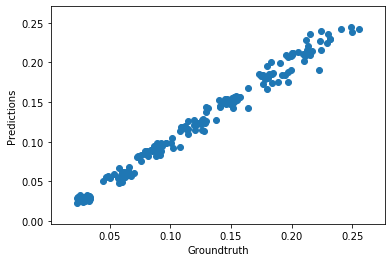

In [73]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [74]:
#%store model_fl_com_x

In [75]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [76]:
# Save model
#joblib.dump(model_fl_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [77]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_y = LinearRegression()

# Fit the model
model_fl_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -1.2579164734085668
RMSE:  0.002528214072329244
The lowest error is:  1.3923098198323491e-05
The highest error is:  0.007268284424705479
The avg. error is:  0.002001508437320024


In [78]:
model_fl_com_y.coef_

array([[-2.05499085e-02, -1.21430643e-17,  9.02056208e-17,
         5.85800789e-04, -2.77555756e-17,  4.16333634e-17,
         9.40067846e-02, -2.85924504e-01, -2.42484540e-02,
         8.04912927e-02,  6.40799915e-02,  1.07140517e-01,
        -1.48100711e-01, -1.59688105e-01]])

In [79]:
model_fl_com_y.intercept_

array([-0.02693472])

Text(0, 0.5, 'Predictions')

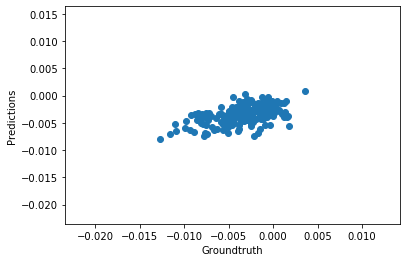

In [80]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [81]:
#%store model_fl_com_y

In [82]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [83]:
# Save model
#joblib.dump(model_fl_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fl_com_y.sav")

## Predict CoM -> Yaw

In [84]:
# Input
X = np.hstack((X_motion_CoM_FL_RR[:, :3], # Previous motion command
               X_motion_CoM_FL_RR[:, -5:-2], # Current motion command
               X_motion_CoM_FL_RR[:, 3:5], # FL (x,y) position
               X_motion_CoM_FL_RR[:, 6:8], # FR (x,y) position
               X_motion_CoM_FL_RR[:, 9:11], # RL (x,y) position
               X_motion_CoM_FL_RR[:, 12:14])) # RR (x, y) position

# Labels
Y = np.array([Y_motion_CoM_FL_RR[:, 2]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_com_theta = LinearRegression()

# Fit the model
model_fl_com_theta.fit(X_train, Y_train)

# Predict
predictions = model_fl_com_theta.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  -0.1275056306852953
RMSE:  0.003364137784874452
The lowest error is:  2.247192883750304e-05
The highest error is:  0.013333947479199817
The avg. error is:  0.002613600563895679


In [85]:
model_fl_com_theta.coef_

array([[-5.42888016e-02,  6.93889390e-18,  9.71445147e-17,
         3.78201854e-02,  1.11022302e-16,  1.66533454e-16,
         2.16411521e-01, -3.78116420e-01,  3.31331453e-01,
         2.77408716e-01, -2.69011456e-01, -3.36199324e-01,
        -1.97770972e-01,  7.38964679e-02]])

In [86]:
model_fl_com_theta.intercept_

array([-0.10753502])

Text(0, 0.5, 'Predictions')

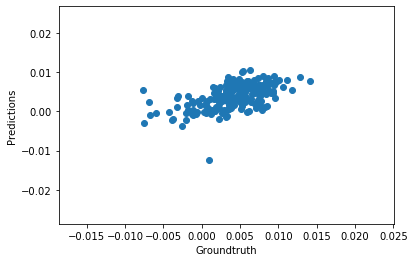

In [87]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")